# Pipeline

In [1]:
# Reload modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

# Import from code root directory
import sys; sys.path.insert(0, '../')

# Imports
from access.amazon_doc2vec_reader import AmoreDoctovecReader
from selection.bounding_boxes import BoundingBoxes
from explanations.tfidf_explainer import TfidfExplainer
from explanations.wordcloud import Wordcloud

# Reader

In [2]:
reader = AmoreDoctovecReader()
options = {}
options['data_directory'] = '/home/eml4u/EML4U/data/amazon-complete'
options['distributions_file'] = '/tmp/amore_test_1.pickle'
reader.initialize(options)
print('Dimensions:', reader.get_dimensions())

AmoreDoctovecReader distributions file: /tmp/amore_test_1.pickle
AmoreDoctovecReader data directory:     /home/eml4u/EML4U/data/amazon-complete
AmoreDoctovecReader: Loading distribution file: /tmp/amore_test_1.pickle
AmazonPickleReader: Reading raw data
AmazonPickleReader: Reading bow50 data
Dimensions: 50


# Detector

In [3]:
bounding_boxes = BoundingBoxes()
options = {}
options['percentile'] = 0.995
options['enclosed_dimensions'] = 50
bounding_boxes.initialize(options)
bounding_boxes.set_reader(reader)
item_ids_0 = bounding_boxes.select_item_ids(reader.get_distribution_ids()[0], reader.get_distribution_ids()[1])
item_ids_1 = bounding_boxes.select_item_ids(reader.get_distribution_ids()[1], reader.get_distribution_ids()[0])
print('Items size 0:', len(item_ids_0))
print('Items size 1:', len(item_ids_1))

BoundingBoxes percentile:                            0.995
BoundingBoxes minimum number of enclosed dimensions: 50
BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
Items size 0: 2310
Items size 1: 4347


# Explainer

Note: TF-IDF values of tokens in single detected documents are just summed up in the current version.

In [8]:
tfidf_explainer = TfidfExplainer()

In [9]:
token_dict_0 = tfidf_explainer.get_token_dict(0, 1, item_ids_0, item_ids_1, reader, 50)
print(token_dict_0)

{'season': 0.0017678782277709979, 'great': 0.0013585335837233326, 'series': 0.000757755130812334, 'best': 0.0007329313802585697, 'excellent': 0.0006974160188156836, 'love': 0.0006903283952794094, 'awesome': 0.00046749282476008316, 'amazing': 0.00042216823902583786, 'wonderful': 0.00041244189665145517, 'seasons': 0.00040687874561840215, 'episodes': 0.0003916292149546638, 'loved': 0.0003620584609037614, 'collection': 0.0003562514146893883, 'fantastic': 0.00031120200430159256, 'favorite': 0.00030989402587626577, 'shows': 0.000307727181815768, 'episode': 0.0002885538104140979, 'perfect': 0.0002707597022969443, 'fun': 0.0002559821376211636, 'condition': 0.00024249419023883272, 'jane': 0.0002267925150456826, 'highly': 0.00021877578403451276, 'wait': 0.00018864919398704132, 'rochester': 0.000184544994467267, 'set': 0.00018385706942199772, 'hilarious': 0.00017521603301877273, 'outstanding': 0.00017436836886753598, 'gift': 0.00017384954558896553, 'loves': 0.00017047322452023886, 'pleased': 0.00

In [10]:
token_dict_1 = tfidf_explainer.get_token_dict(1, 0, item_ids_1, item_ids_0, reader, 50)
print(token_dict_1)

{'movie': 0.0057426881840407, 'film': 0.0026740202257373707, 'bad': 0.0023078893041135772, 'waste': 0.0019878126004686495, 'money': 0.0017938174229347528, 'don': 0.0016987992587741236, 'worst': 0.0015641966938124347, 'just': 0.001478921411728566, 'like': 0.0014582438636611872, 'time': 0.0012316820825350014, 'boring': 0.0012249181579350574, 'movies': 0.0011582884676040863, 'horrible': 0.0010920371735459187, 'acting': 0.0010702351241392732, 'awful': 0.001039640633099535, 'poor': 0.0010122225866272382, 'plot': 0.0010021448987033287, 'did': 0.0009733816895209889, 'terrible': 0.0009725783740175077, 'really': 0.0009719797958441375, 'people': 0.0009509320181930831, 'story': 0.0009469503569234457, 'minutes': 0.0008858186563753694, 'make': 0.0008849153840496968, 'stupid': 0.000879257017937022, 'didn': 0.0008064922508337412, 'seen': 0.0007526188129590805, 'horror': 0.0007349953953675848, 'disappointed': 0.0007209071273353816, 'know': 0.0007199966589772446, 'watch': 0.0007054714438621938, 'funny'

### Visual representation

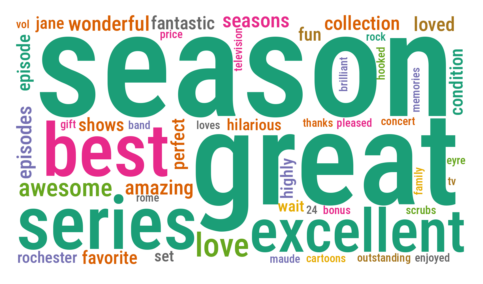

In [11]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_0))

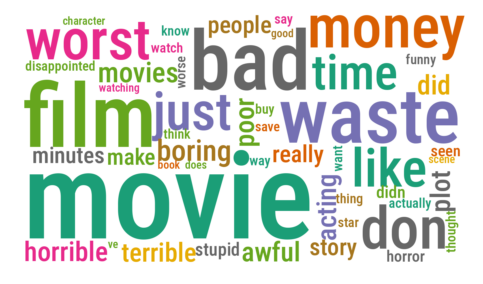

In [12]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_1))